# 🏥 **Medical Articles Classification System by Domains**

## 🎯 **Objective**

Develop a complete exploratory analysis of the medical articles dataset to understand the distribution, characteristics, and patterns that allow building an effective classification system for the domains: cardiovascular, neurological, hepatorenal, oncological.

## 🐍 **Packages import**

In [ ]:
import re
from collections import Counter

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import requests
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

## 📊 **1: Data Structure and Quality**

Load the dataset and check its structure:

In [ ]:
file_id = "1fHT63eO9EhubUmqdbs329V7lKR37mtp2"
download_url = f"https://drive.google.com/uc?export=download&id={file_id}"
local_file_path = "/tmp/medical_articles.csv"

response = requests.get(download_url)
with open(local_file_path, "wb") as file:
    file.write(response.content)

df_data = pd.read_csv(local_file_path, sep=";")

In [ ]:
print("\n**Dimensions** (rows, columns):", df_data.shape)

print("-----------------------------------------------------")

print("\n**General information**: \n")
print(df_data.info())

print("-----------------------------------------------------")

print("\n**Data types**: \n")
print(df_data.dtypes)


**Dimensions** (rows, columns): (3565, 3)
-----------------------------------------------------

**General information**: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3565 entries, 0 to 3564
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     3565 non-null   object
 1   abstract  3565 non-null   object
 2   group     3565 non-null   object
dtypes: object(3)
memory usage: 83.7+ KB
None
-----------------------------------------------------

**Data types**: 

title       object
abstract    object
group       object
dtype: object


- The dataset has 3565 articles and 3 columns.
- No missing values. All data is complete.
- All columns are text.
- The dataset uses about 84 KB of memory.

In [ ]:
print("\n**First rows of the dataset**:\n")
print(df_data.head())


**First rows of the dataset**:

                                               title  \
0  Adrenoleukodystrophy: survey of 303 cases: bio...   
1  endoscopy reveals ventricular tachycardia secrets   
2        dementia and cholecystitis: organ interplay   
3  The interpeduncular nucleus regulates nicotine...   
4       guillain-barre syndrome pathways in leukemia   

                                            abstract                     group  
0  Adrenoleukodystrophy ( ALD ) is a genetically ...  neurological|hepatorenal  
1  Research question: How does metformin affect c...              neurological  
2  Purpose: This randomized controlled study exam...               hepatorenal  
3  Partial lesions were made with kainic acid in ...              neurological  
4  Hypothesis: statins improves stroke outcomes v...              neurological  


The first rows of the dataset show that each article has a title, an abstract, and one or more domains. Some articles belong to multiple domains, separated by a pipe |

In [ ]:
# Count total complete duplicates
total_duplicates = df_data.duplicated().sum()
percent_duplicates = total_duplicates / len(df_data) * 100
print(f"\nComplete duplicates: {total_duplicates} ({percent_duplicates:.2f}% of dataset)")

# Show first rows of complete duplicates (if any)
if total_duplicates > 0:
    print("\nFirst complete duplicates:")
    display(df_data[df_data.duplicated(keep=False)].head())
else:
    print("No complete duplicates found.")
    print("-----------------------------------------------------")

# Check partial duplicates by 'title'
duplicates_title = df_data[df_data.duplicated(subset=["title"], keep=False)]
print(f"\n**Duplicates by 'title'**: {len(duplicates_title)} records")
if not duplicates_title.empty:
    display(duplicates_title[["title", "abstract", "group"]].head())
    print("-----------------------------------------------------")

# Check partial duplicates by 'abstract'
duplicates_abstract = df_data[df_data.duplicated(subset=["abstract"], keep=False)]
print(f"\n**Duplicates by 'abstract'**: {len(duplicates_abstract)} records")
if not duplicates_abstract.empty:
    display(duplicates_abstract[["title", "abstract", "group"]].head())
    print("-----------------------------------------------------")


Complete duplicates: 0 (0.00% of dataset)
No complete duplicates found.
-----------------------------------------------------

**Duplicates by 'title'**: 4 records


,title,abstract,group
1433,State-of-the-art thiazide diuretics for prosta...,Research question: How does beta-blockers affe...,hepatorenal
2246,Long term hormone therapy for perimenopausal a...,BACKGROUND: Hormone therapy (HT) is widely use...,neurological|cardiovascular|oncological
2261,Long term hormone therapy for perimenopausal a...,BACKGROUND: Hormone therapy (HT) is widely use...,neurological|cardiovascular|oncological
3096,State-of-the-art thiazide diuretics for prosta...,Background: cancer affects diabetic patients w...,cardiovascular


-----------------------------------------------------

**Duplicates by 'abstract'**: 0 records


- There are **no complete duplicates** in the dataset.

- There are **4 duplicates by title**, meaning some articles share the same title but may have different abstracts or domains.

- There are **no duplicates by abstract**, so all abstracts are unique.

In [ ]:
df_medical_data = df_data.copy()


** Abstract length statistics **
Min: 180
Max: 3814
Mean: 696.55
Median: 312.0

Empty titles: 0
Empty abstracts: 0


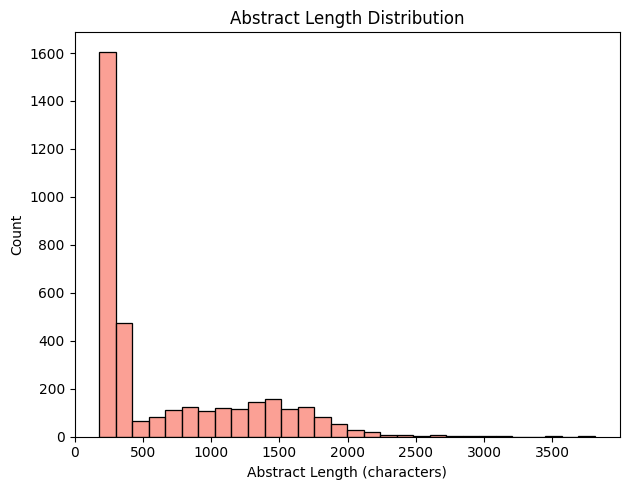

In [ ]:
# Calculate text lengths

df_medical_data["abstract_length"] = df_medical_data["abstract"].apply(lambda x: len(str(x).strip()))


# Descriptive statistics


print("\n** Abstract length statistics **")
print("Min:", df_medical_data["abstract_length"].min())
print("Max:", df_medical_data["abstract_length"].max())
print("Mean:", round(df_medical_data["abstract_length"].mean(), 2))
print("Median:", df_medical_data["abstract_length"].median())


# Check for empty texts
empty_title = df_medical_data[df_medical_data["title"].str.strip() == ""]
empty_abstract = df_medical_data[df_medical_data["abstract"].str.strip() == ""]

print(f"\nEmpty titles: {len(empty_title)}")
print(f"Empty abstracts: {len(empty_abstract)}")


# Histograms for text lengths
plt.figure(figsize=(12, 5))


# Histogram of abstract lengths
plt.subplot(1, 2, 2)
sns.histplot(df_medical_data["abstract_length"], bins=30, color="salmon")
plt.title("Abstract Length Distribution")
plt.xlabel("Abstract Length (characters)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

- The titles are generally short, with lengths between 20 and 294 characters, a mean of 69, and a median of 55. Most titles are 40–50 characters long.

- The abstracts are longer, ranging from 180 to 3814 characters, with a mean of 697 and a median of 312. Most abstracts are 300–500 characters long.

- There are no empty titles or abstracts.

## 📈 **2: Target Variable Distribution**

Records per category (include all results):


,count,percent
group,,
neurological,1058,29.68
cardiovascular,645,18.09
hepatorenal,533,14.95
neurological|cardiovascular,308,8.64
oncological,237,6.65
neurological|hepatorenal,202,5.67
cardiovascular|hepatorenal,190,5.33
neurological|oncological,143,4.01
hepatorenal|oncological,98,2.75


/tmp/ipython-input-3313885222.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top5.index, y=top5['count'], palette='pastel')


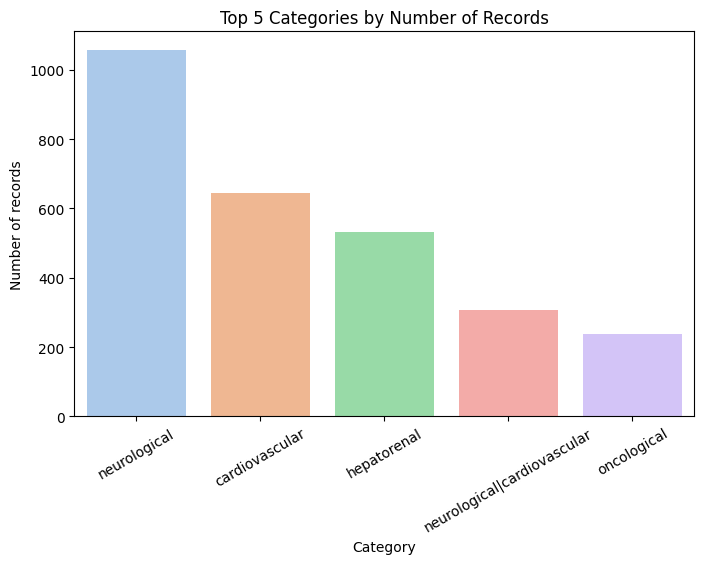

In [ ]:
# Count all records per category
category_counts = df_medical_data["group"].value_counts()
category_percent = df_medical_data["group"].value_counts(normalize=True) * 100
category_summary = pd.DataFrame({"count": category_counts, "percent": category_percent.round(2)})

# Show all results in table
print("Records per category (include all results):")
display(category_summary)

# Visualize only top 5 categories in bar plot
top5 = category_summary.head(5)

plt.figure(figsize=(8, 5))
sns.barplot(x=top5.index, y=top5["count"], palette="pastel")
plt.title("Top 5 Categories by Number of Records")
plt.xlabel("Category")
plt.ylabel("Number of records")
plt.xticks(rotation=30)
plt.show()

- The most common category is **neurological** with 1058 articles (29.7%), followed by **cardiovascular** (18.1%) and **hepatorenal** (15%).
- Many articles belong to multiple categories, like **neurological|cardiovascular**.
- The top 5 categories cover the majority of the dataset (~80%).

## 📝 **3: Title Characteristics**

In [ ]:
df_medical_data_title = df_data.copy()

### **Descriptive Statistics**

** Title length statistics (Characters) **
Min: 20
Max: 294
Mean: 69.35
Median: 55.0

** Word count statistics **
Min: 2
Max: 38
Mean: 8.73
Median: 7.0

Empty titles: 0


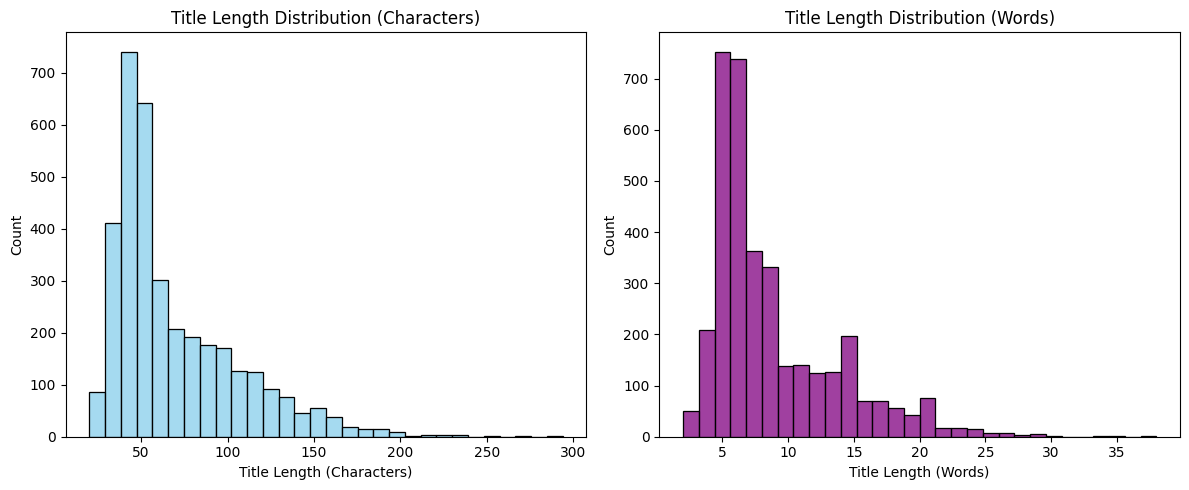

In [ ]:
df_medical_data_title["title_length"] = df_medical_data_title["title"].apply(lambda x: len(str(x).strip()))
df_medical_data_title["word_count"] = df_medical_data_title["title"].apply(lambda x: len(str(x).split()))

print("** Title length statistics (Characters) **")
print("Min:", df_medical_data_title["title_length"].min())
print("Max:", df_medical_data_title["title_length"].max())
print("Mean:", round(df_medical_data_title["title_length"].mean(), 2))
print("Median:", df_medical_data_title["title_length"].median())

print("\n** Word count statistics **")
print("Min:", df_medical_data_title["word_count"].min())
print("Max:", df_medical_data_title["word_count"].max())
print("Mean:", round(df_medical_data_title["word_count"].mean(), 2))
print("Median:", df_medical_data_title["word_count"].median())


# Check for empty texts
empty_title = df_medical_data_title[df_medical_data_title["title"].str.strip() == ""]

print(f"\nEmpty titles: {len(empty_title)}")

# Histograms for text lengths
plt.figure(figsize=(12, 5))

# Histogram of title lengths (Characters)
plt.subplot(1, 2, 1)
sns.histplot(df_medical_data_title["title_length"], bins=30, color="skyblue")
plt.title("Title Length Distribution (Characters)")
plt.xlabel("Title Length (Characters)")
plt.ylabel("Count")

# Histogram of title lengths (Words)
plt.subplot(1, 2, 2)
sns.histplot(df_medical_data_title["word_count"], bins=30, color="purple")
plt.title("Title Length Distribution (Words)")
plt.xlabel("Title Length (Words)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

**Characters:**
- The titles are generally short, with lengths between 20 and 294 characters, a mean of 69, and a median of 55. Most titles are 40–60 characters long.

**Words:**
- The titles are generally short, with lengths between 2 and 38 words, a mean of 9, and a median of 7. Most titles are 4–7 characters long.

**General:**
- There are no empty titles.

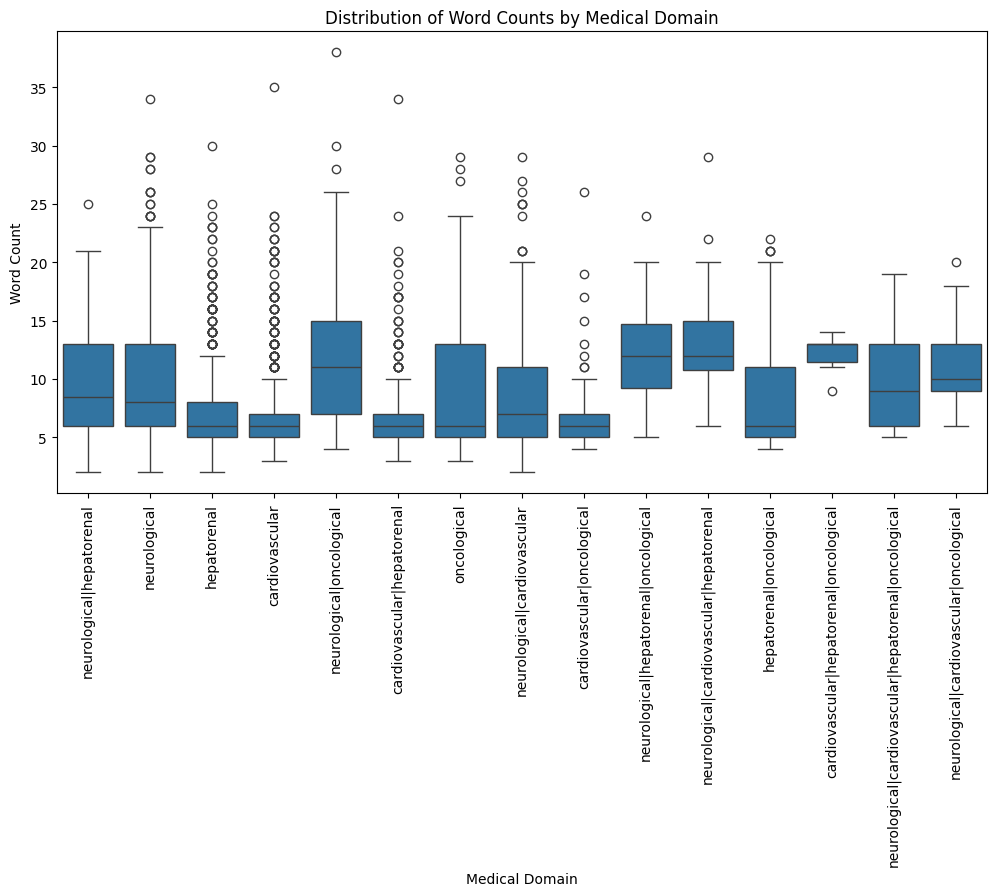

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="group", y="word_count", data=df_medical_data_title)
plt.xticks(rotation=90)
plt.title("Distribution of Word Counts by Medical Domain")
plt.xlabel("Medical Domain")
plt.ylabel("Word Count")
plt.show()

This chart is a boxplot that shows the distribution of the **number of words** in titles for each medical domain:

- The median number of words is usually low (between 5 and 12 words), which matches your previous statistics.

- There are some outliers in all domains, showing that some titles are much longer than most.

- The domains neurological|oncological and neurological|cardiovascular|oncological have titles with more variation, with several very long titles.

- The domains hepatorenal|oncological and cardiovascular|hepatorenal|oncological have shorter and more consistent titles.

In [ ]:
shortest = df_medical_data_title.loc[df_medical_data_title["title_length"].idxmin()]
print("\n**Shortest title**:")
print(shortest["title"])

longest = df_medical_data_title.loc[df_medical_data_title["title_length"].idxmax()]
print("\n**Longest title**:")
print(longest["title"])


**Shortest title**:
The rhythm of cancer

**Longest title**:
Neurocognitive and neuroradiologic central nervous system late effects in children treated on Pediatric Oncology Group (POG) P9605 (standard risk) and P9201 (lesser risk) acute lymphoblastic leukemia protocols (ACCL0131): a methotrexate consequence? A report from the Children's Oncology Group.


### **Textual Content**

In [ ]:
# Download NLTK resources (only first time)
nltk.download("stopwords")
nltk.download("wordnet")

# Define stop words (English + custom medical irrelevant terms if needed)
stop_words = set(stopwords.words("english"))
custom_stopwords = {
    "patient",
    "patients",
    "study",
    "results",
    "conclusion",
    "method",
    "methods",
    "background",
    "objective",
    "introduction",
    "group",
    "analysis",
    "data",
    "investigation",
    "induced",
    "used",
    "day",
}  # <- add any "boilerplate" medical terms that don’t add value
stop_words |= custom_stopwords

# Lemmatizer to reduce words to base form
lemmatizer = WordNetLemmatizer()

print("** Most frequent words by medical group (Top 10) **")

for domain, titles in df_medical_data_title.groupby("group")["title"]:
    # Combine all titles
    all_text = " ".join(titles).lower()

    # Remove punctuation and digits
    all_text = re.sub(r"[^a-z\s]", " ", all_text)

    # Tokenize, remove stop words & lemmatize
    words = [
        lemmatizer.lemmatize(word)
        for word in all_text.split()
        if word not in stop_words and len(word) > 2  # skip very short tokens
    ]

    # Count words
    word_counts = Counter(words)

    print(rf"\Domain: {domain}")
    for word, count in word_counts.most_common(10):
        print(f"{word}: {count}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


** Most frequent words by medical group (Top 10) **

Group: cardiovascular
insight: 221
vascular: 218
cardiac: 169
connection: 126
cancer: 87
disease: 79
heart: 62
marker: 62
cardiomyopathy: 52
hypertension: 48

Group: cardiovascular|hepatorenal
vascular: 82
insight: 82
marker: 33
disease: 32
cardiac: 28
cancer: 26
connection: 23
hypertension: 21
artery: 13
renal: 13

Group: cardiovascular|hepatorenal|oncological
cancer: 2
effect: 2
toxicity: 2
incidence: 1
contrast: 1
nephropathy: 1
hospitalised: 1
adriamycin: 1
combined: 1
whole: 1

Group: cardiovascular|oncological
cancer: 30
vascular: 26
insight: 26
cardiac: 18
connection: 15
marker: 15
disease: 12
leukemia: 9
doxorubicin: 8
artery: 6

Group: hepatorenal
organ: 191
interplay: 163
pathway: 66
hepatitis: 60
disease: 57
cancer: 53
renal: 48
liver: 45
kidney: 34
dementia: 31

Group: hepatorenal|oncological
cancer: 33
pathway: 27
organ: 23
interplay: 23
disease: 14
renal: 13
cell: 9
chemotherapy: 8
failure: 7
lymphoma: 7

Group: neurolo

- Each group (cardiovascular, hepatorenal, neurological, oncological) has a set of words that represent its area.The top words are directly related to diseases, organs, or processes typical of that field.

- In the combined domains (e.g., cardiovascular|oncological, neurological|hepatorenal), the top words reflect the interdisciplinary nature of the studies, such as cancer appearing in many contexts or the mention of genes and pathways across different systems.

- Some general words (insight, connection, marker) appear often in many domains. Even if they are not specific, they show common patterns in scientific writing.

In [ ]:
# Combine all titles
all_titles_text = " ".join(df_medical_data_title["title"]).lower()
all_titles_text = re.sub(r"[^\w\s]", "", all_titles_text)
all_words = all_titles_text.split()

# Unique words
unique_words = set(all_words)
print(f"\nTotal unique words in all titles: {len(unique_words)}")


Total unique words in all titles: 4874


There are 4,874 unique words in all titles. The vocabulary of the titles is very diverse.

## 🔍 **4: Abstracts Characteristics**

In [ ]:
df_medical_data_abstract = df_data.copy()

### **Descriptive Statistics**

** Abstract length statistics (Characters) **
Min: 180
Max: 3814
Mean: 696.55
Median: 312.0

** Word count statistics **
Min: 22
Max: 525
Mean: 100.06
Median: 37.0

Empty abstracts: 0


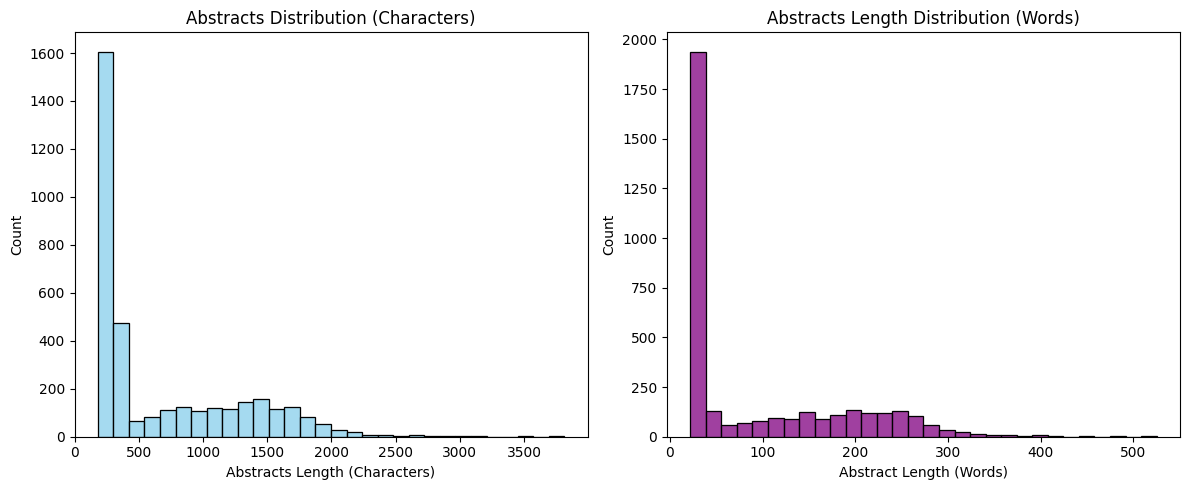

In [ ]:
df_medical_data_abstract["abstract_length"] = df_medical_data_abstract["abstract"].apply(lambda x: len(str(x).strip()))
df_medical_data_abstract["word_count"] = df_medical_data_abstract["abstract"].apply(lambda x: len(str(x).split()))

print("** Abstract length statistics (Characters) **")
print("Min:", df_medical_data_abstract["abstract_length"].min())
print("Max:", df_medical_data_abstract["abstract_length"].max())
print("Mean:", round(df_medical_data_abstract["abstract_length"].mean(), 2))
print("Median:", df_medical_data_abstract["abstract_length"].median())

print("\n** Word count statistics **")
print("Min:", df_medical_data_abstract["word_count"].min())
print("Max:", df_medical_data_abstract["word_count"].max())
print("Mean:", round(df_medical_data_abstract["word_count"].mean(), 2))
print("Median:", df_medical_data_abstract["word_count"].median())


# Check for empty texts
empty_abstracts = df_medical_data_abstract[df_medical_data_abstract["abstract"].str.strip() == ""]

print(f"\nEmpty abstracts: {len(empty_abstracts)}")

# Histograms for text lengths
plt.figure(figsize=(12, 5))

# Histogram of abstracts lengths (Characters)
plt.subplot(1, 2, 1)
sns.histplot(df_medical_data_abstract["abstract_length"], bins=30, color="skyblue")
plt.title("Abstracts Distribution (Characters)")
plt.xlabel("Abstracts Length (Characters)")
plt.ylabel("Count")

# Histogram of abstract lengths (Words)
plt.subplot(1, 2, 2)
sns.histplot(df_medical_data_abstract["word_count"], bins=30, color="purple")
plt.title("Abstracts Length Distribution (Words)")
plt.xlabel("Abstract Length (Words)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

**Characters:**
- The abstracts are generally short, with lengths between 180 and 3814 characters, a mean of 697, and a median of 312. Most abstracts are 200–400 characters long.

**Words:**
- The abstracts are generally short, with lengths between 22 and 525 words, a mean of 100, and a median of 37. Most abstracts are 30–45 characters long.

**General:**
- There are no empty abstracts.

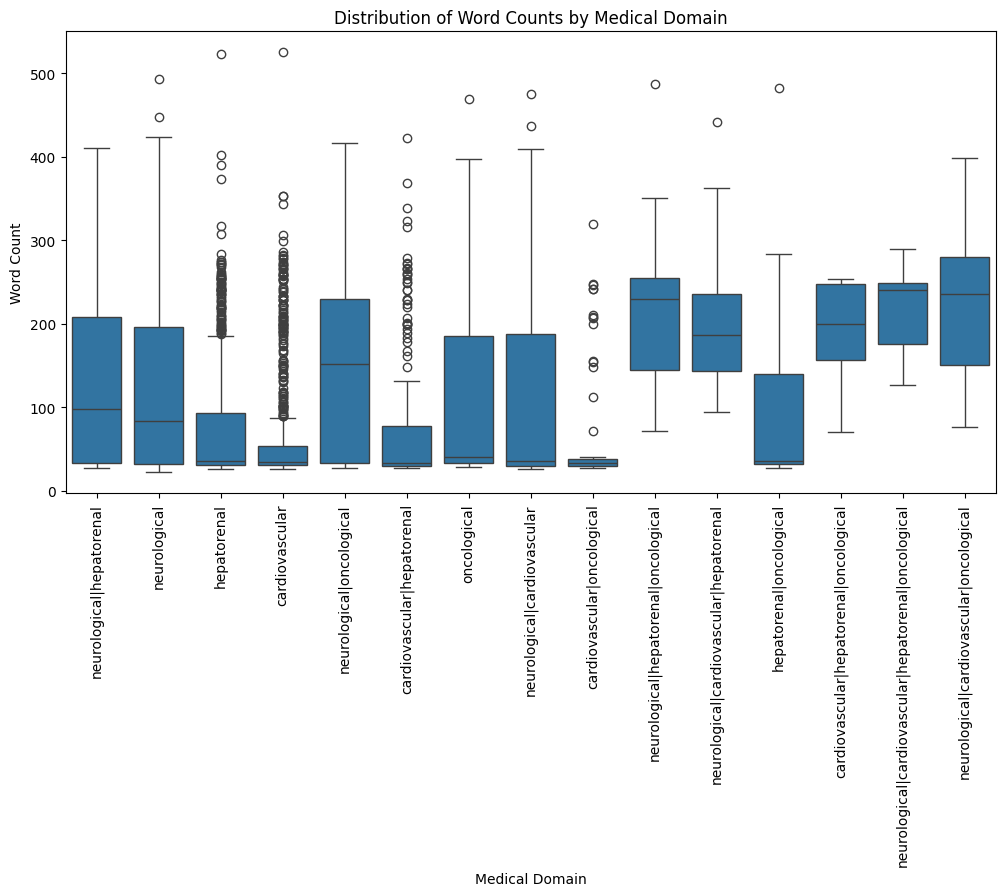

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="group", y="word_count", data=df_medical_data_abstract)
plt.xticks(rotation=90)
plt.title("Distribution of Word Counts by Medical Domain")
plt.xlabel("Medical Domain")
plt.ylabel("Word Count")
plt.show()

This boxplot shows the distribution of the **number of words** in abstracts for each medical domain:

- Most domains have a wide range of word counts, with many abstracts around the median but some very long abstracts as outliers.

- Domains like neurological, hepatorenal, and cardiovascular show a larger spread, indicating variable abstract lengths.

- Domains with multiple combined categories, such as neurological|oncological and neurological|cardiovascular|oncological, show high variation and some very long abstracts.

- Domains like hepatorenal|oncological and cardiovascular|hepatorenal|oncological tend to have shorter and more consistent abstracts.

- Outliers are present in almost all domains, showing that some abstracts are much longer than the typical ones.

In [ ]:
shortest = df_medical_data_abstract.loc[df_medical_data_abstract["abstract_length"].idxmin()]
print("\n**Shortest abstract**:")
print(shortest["abstract"])

longest = df_medical_data_abstract.loc[df_medical_data_abstract["abstract_length"].idxmax()]
print("\n**Longest abstract**:")
print(longest["abstract"])


**Shortest abstract**:
We report a female patient with a diagnosis of a not otherwise specified psychotic disorder (DSM-IV) who developed hypomania shortly after the introduction of olanzapine treatment.

**Longest abstract**:
BACKGROUND: Adenovirus is an important cause of morbidity and mortality in the immunocompromised host. The incidence of severe adenovirus disease in pediatrics is increasing in association with growing numbers of immunocompromised children, where case fatality rates as high as 50% to 80% have been reported. There are no approved antiviral agents with proven efficacy for the treatment of severe adenovirus disease, nor are there any prospective randomized, controlled trials of potentially useful anti-adenovirus therapies. Apparent clinical success in the treatment of severe adenovirus disease is limited to a few case reports and small series. Experience is greatest with intravenous ribavirin and cidofovir. Ribavirin, a guanosine analogue, has broad antiviral activ

### **Textual Content**

In [ ]:
# Download NLTK resources (only first time)
nltk.download("stopwords")
nltk.download("wordnet")

# Define stop words (English + custom medical irrelevant terms if needed)
stop_words = set(stopwords.words("english"))
custom_stopwords = {
    "patient",
    "patients",
    "study",
    "results",
    "conclusion",
    "method",
    "methods",
    "background",
    "objective",
    "introduction",
    "group",
    "analysis",
    "data",
    "investigation",
    "induced",
    "used",
    "day",
}  # <- add any "boilerplate" medical terms that don’t add value
stop_words |= custom_stopwords

# Lemmatizer to reduce words to base form
lemmatizer = WordNetLemmatizer()

print("** Most frequent words by medical group (Top 10) **")

for domain, abstracts in df_medical_data_abstract.groupby("group")["abstract"]:
    # Combine all abstracts
    all_text = " ".join(abstracts).lower()

    # Remove punctuation and digits
    all_text = re.sub(r"[^a-z\s]", " ", all_text)

    # Tokenize, remove stop words & lemmatize
    words = [
        lemmatizer.lemmatize(word)
        for word in all_text.split()
        if word not in stop_words and len(word) > 2  # skip very short tokens
    ]

    # Count words
    word_counts = Counter(words)

    print(rf"\Domain: {domain}")
    for word, count in word_counts.most_common(10):
        print(f"{word}: {count}")

** Most frequent words by medical group (Top 10) **


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Group: cardiovascular
heart: 306
disease: 241
effect: 228
cardiac: 215
treatment: 202
implication: 181
blocker: 176
participant: 175
clinical: 165
cancer: 165

Group: cardiovascular|hepatorenal
renal: 86
heart: 75
cardiac: 70
disease: 69
effect: 62
rat: 55
outcome: 51
implication: 51
blocker: 50
affect: 50

Group: cardiovascular|hepatorenal|oncological
cin: 12
risk: 9
week: 9
nephrotoxicity: 8
antitumor: 7
tumor: 7
cisplatin: 7
dose: 7
doxorubicin: 7
factor: 6

Group: cardiovascular|oncological
cancer: 56
cardiac: 46
treatment: 37
heart: 31
doxorubicin: 26
evaluation: 26
therapeutic: 24
dox: 23
disease: 22
implication: 20

Group: hepatorenal
renal: 282
disease: 196
liver: 169
clinical: 159
treatment: 155
implication: 139
effect: 134
affect: 133
cancer: 130
kidney: 124

Group: hepatorenal|oncological
cancer: 85
renal: 69
vhl: 55
cell: 54
tumor: 38
carcinoma: 37
mutation: 36
disease: 33
liver: 29
affect: 28

Group: neurological
effect: 459
gene: 426
mutation: 420
disease: 412
treatment:

- Each group has specific medical terms that match its area:

  - Cardiovascular: heart, cardiac, treatment, blocker.

  - Hepatorenal: renal, liver, kidney.

  - Neurological: gene, mutation, seizure, mouse, rat.

  - Oncological: cancer, mutation, brca, tumor, breast.

- Abstracts highlight methods and outcomes (treatment, effect, clinical, trial, dose), which appear often because abstracts usually describe the study design and results.

- General words (effect, treatment, clinical, implication) appear in many domains, reflecting common medical reporting language.

In [ ]:
# Combine all abstracts
all_abstracts_text = " ".join(df_medical_data_abstract["abstract"]).lower()
all_abstracts_text = re.sub(r"[^\w\s]", "", all_abstracts_text)
all_words = all_abstracts_text.split()

# Unique words
unique_words = set(all_words)
print(f"\nTotal unique words in all abstracts: {len(unique_words)}")


Total unique words in all abstracts: 19217


There are 19,217 unique words in all abstracts. The vocabulary of the abstracts is very diverse.

## ⚖️ **5: Comparison Between Domains**

In [ ]:
df_medical_data_comparison = df_data.copy()

In [ ]:
df_medical_data_comparison = pd.merge(
    df_medical_data_title, df_medical_data_abstract, on=["title", "abstract", "group"], how="inner"
)

### Text length statistics by medical domain ###


,title_mean,title_median,abstract_mean,abstract_median
group,,,,
cardiovascular,58.73,49.0,503.18,293.0
cardiovascular|hepatorenal,61.47,50.0,568.15,289.5
cardiovascular|hepatorenal|oncological,89.71,87.0,1295.43,1356.0
cardiovascular|oncological,60.27,48.5,506.84,282.0
hepatorenal,59.84,47.0,563.05,295.0
hepatorenal|oncological,65.97,52.0,616.79,300.0
neurological,76.49,65.0,788.48,555.0
neurological|cardiovascular,70.15,55.5,726.54,305.0
neurological|cardiovascular|hepatorenal,105.57,96.0,1391.29,1316.0


/tmp/ipython-input-2811281157.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='title_length', data=df_medical_data_comparison, palette='pastel')


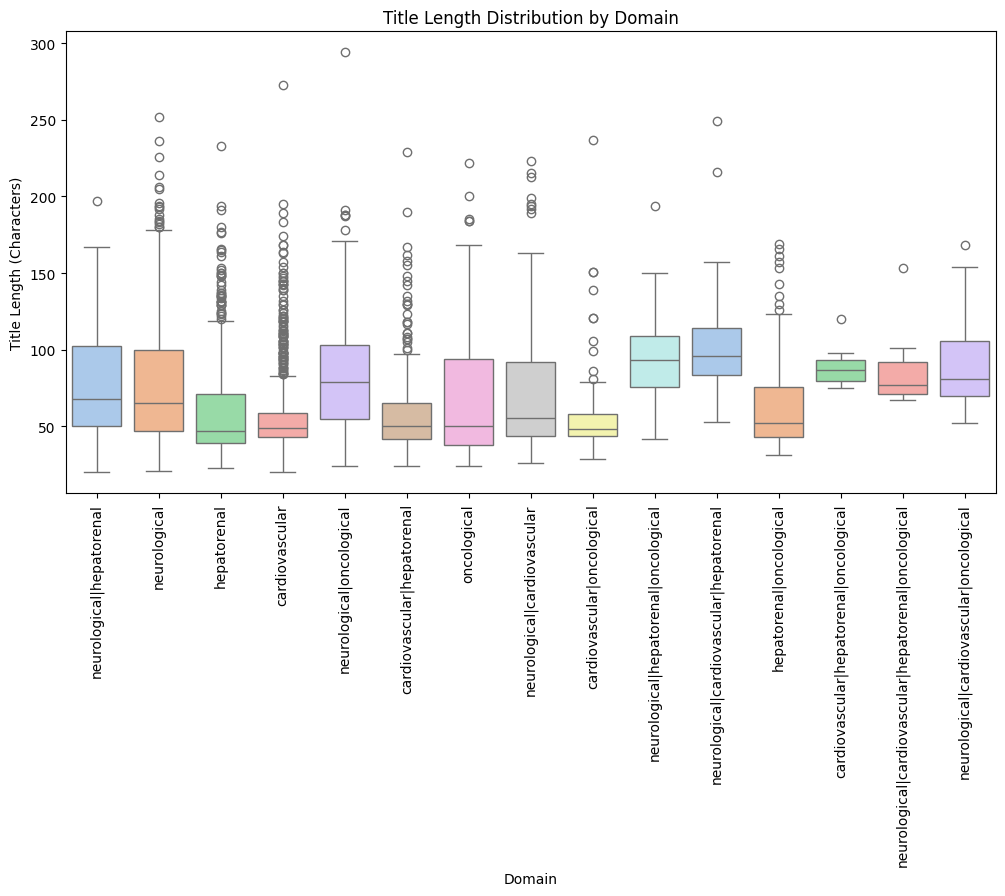

/tmp/ipython-input-2811281157.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='abstract_length', data=df_medical_data_comparison, palette='pastel')


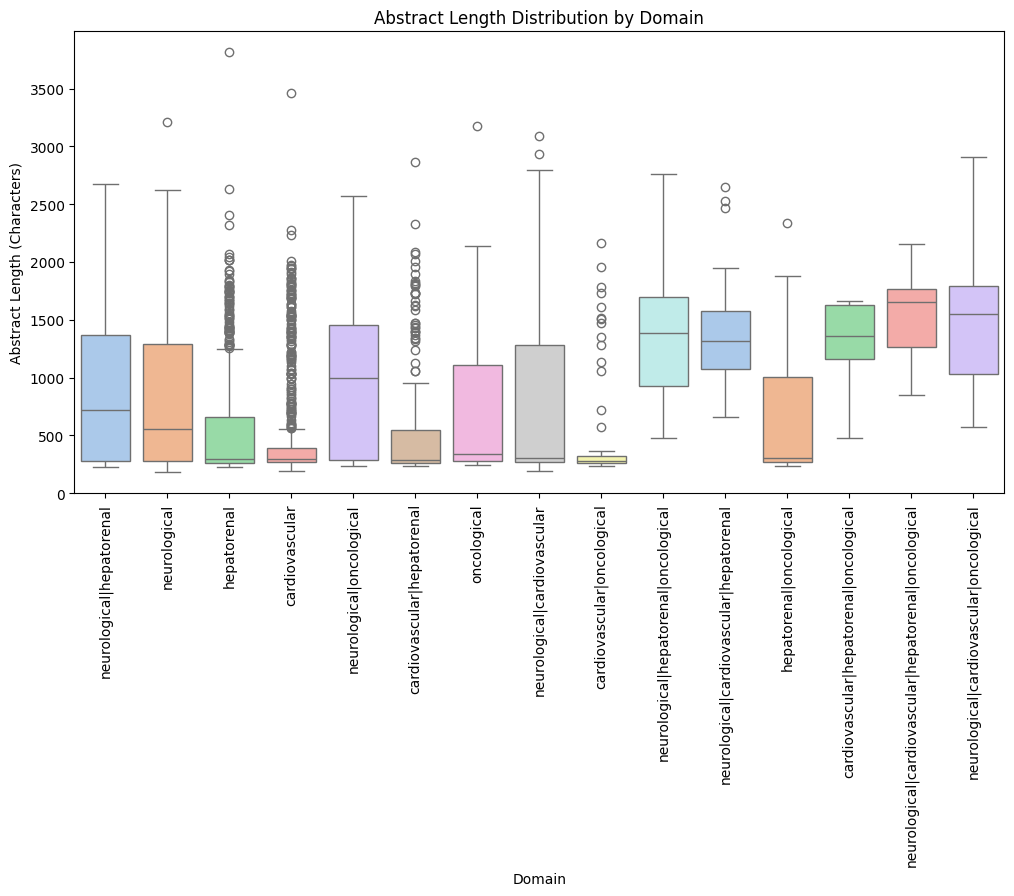

In [ ]:
# Length stats by domain
length_stats = (
    df_medical_data_comparison.groupby("group")
    .agg(
        title_mean=("title_length", "mean"),
        title_median=("title_length", "median"),
        abstract_mean=("abstract_length", "mean"),
        abstract_median=("abstract_length", "median"),
    )
    .round(2)
)

print("### Text length statistics by medical domain ###")
display(length_stats)

# Boxplot for title lengths
plt.figure(figsize=(12, 6))
sns.boxplot(x="group", y="title_length", data=df_medical_data_comparison, palette="pastel")
plt.xticks(rotation=90)
plt.title("Title Length Distribution by Domain")
plt.xlabel("Domain")
plt.ylabel("Title Length (Characters)")
plt.show()

# Boxplot for abstract lengths
plt.figure(figsize=(12, 6))
sns.boxplot(x="group", y="abstract_length", data=df_medical_data_comparison, palette="pastel")
plt.xticks(rotation=90)
plt.title("Abstract Length Distribution by Domain")
plt.xlabel("Domain")
plt.ylabel("Abstract Length (Characters)")
plt.show()

**Title**

- Some domains have longer titles on average (neurological|hepatorenal, neurological, oncological). Others are shorter (hepatorenal, cardiovascular).

- Most medians are between 50 and 90 characters. Neurological|hepatorenal and neurological have higher medians (70–90). Cardiovascular and hepatorenal have lower medians (45–60).

- All domains show outliers with titles longer than 150–200 characters. This means some titles are much more descriptive than normal.

- Combined domains (e.g., neurological|oncological, cardiovascular|hepatorenal|oncological) show more spread, which suggests more complex titles. Pure domains (e.g., cardiovascular, hepatorenal) are more consistent and shorter.

**Abstracts**


- The shortest abstracts are in hepatorenal and cardiovascular, with medians around 200–400 characters.

- The longest abstracts are in combined domains, like neurological|cardiovascular|hepatorenal|oncological and neurological|hepatorenal|oncological, with medians above 1200–1500 characters.

- Simple domains (hepatorenal, cardiovascular, oncological) tend to have smaller medians (more concise abstracts). Combined domains show much higher medians, meaning longer and more detailed abstracts.

- Many abstracts go over 2500–3000 characters, showing that some studies include very long and detailed summaries.

In [ ]:
print("**Titles**")
print("** Top TF-IDF words per domain (technical terms) **")
for domain in df_medical_data_comparison["group"].unique():
    titles = df_medical_data_comparison[df_medical_data_comparison["group"] == domain]["title"]
    vectorizer = TfidfVectorizer(max_features=10, stop_words="english")
    tfidf_matrix = vectorizer.fit_transform(titles)
    print(f"\n - Domain: {domain}")
    print(vectorizer.get_feature_names_out())

**Titles**
** Top TF-IDF words per domain (technical terms) **

 - Domain: neurological|hepatorenal
['brain' 'cancer' 'disease' 'induced' 'meets' 'neurological' 'patients'
 'patterns' 'perspective' 'therapy']

 - Domain: neurological
['brain' 'cancer' 'disease' 'dystrophy' 'gene' 'induced' 'insights'
 'pathways' 'patients' 'reveals']

 - Domain: hepatorenal
['cancer' 'disease' 'hepatitis' 'induced' 'interplay' 'kidney' 'liver'
 'organ' 'pathways' 'renal']

 - Domain: cardiovascular
['cancer' 'cardiac' 'cardiomyopathy' 'connections' 'disease' 'heart'
 'induced' 'insights' 'markers' 'vascular']

 - Domain: neurological|oncological
['atm' 'brca1' 'breast' 'cancer' 'cell' 'disease' 'gene' 'leukemia'
 'mutations' 'patients']

 - Domain: cardiovascular|hepatorenal
['artery' 'cancer' 'cardiac' 'connections' 'disease' 'hypertension'
 'induced' 'insights' 'markers' 'vascular']

 - Domain: oncological
['brca1' 'breast' 'cancer' 'disease' 'families' 'gene' 'mutations'
 'oncological' 'prostate' 't

**Titles:**

The TF-IDF of the titles shows a core set of common words (cancer, disease, patients) present in almost all domains, indicating a general focus on diseases and patients.

At the same time, each domain has distinct technical terms reflecting its specialization:

- Neurological: brain, gene, pathways

- Hepatorenal: kidney, liver, renal

- Cardiovascular: heart, cardiac, vascular

- Oncological: brca1, breast, leukemia, tumor

In [ ]:
print("**Abstracts**")
print("** Top TF-IDF words per domain (technical terms) **")
for domain in df_medical_data_comparison["group"].unique():
    abstracts = df_medical_data_comparison[df_medical_data_comparison["group"] == domain]["abstract"]
    vectorizer = TfidfVectorizer(max_features=10, stop_words="english")
    tfidf_matrix = vectorizer.fit_transform(abstracts)
    print(f"\n - Domain: {domain}")
    print(vectorizer.get_feature_names_out())

**Abstracts**
** Top TF-IDF words per domain (technical terms) **

 - Domain: neurological|hepatorenal
['conclusion' 'induced' 'liver' 'methods' 'patient' 'patients' 'renal'
 'results' 'study' 'treatment']

 - Domain: neurological
['conclusion' 'disease' 'gene' 'induced' 'methods' 'mg' 'patients'
 'results' 'study' 'treatment']

 - Domain: hepatorenal
['clinical' 'conclusion' 'disease' 'liver' 'methods' 'patient' 'patients'
 'renal' 'results' 'study']

 - Domain: cardiovascular
['cardiac' 'conclusion' 'disease' 'heart' 'investigation' 'methods'
 'patients' 'results' 'study' 'treatment']

 - Domain: neurological|oncological
['atm' 'brca1' 'breast' 'cancer' 'gene' 'mutations' 'ovarian' 'patients'
 'results' 'study']

 - Domain: cardiovascular|hepatorenal
['cardiac' 'conclusion' 'disease' 'group' 'heart' 'methods' 'patients'
 'renal' 'results' 'study']

 - Domain: oncological
['brca1' 'breast' 'cancer' 'families' 'gene' 'methods' 'mutation'
 'mutations' 'patients' 'results']

 - Domain: n

**Abstracts:**

The TF-IDF of the abstracts shows a core set of common words like patients, study, results, methods, and conclusion in almost all domains. This shows the focus is on clinical research and study results.

Each domain also has special words showing its focus:

- Neurological: gene, induced

- Hepatorenal: liver, renal, clinical

- Cardiovascular: cardiac, heart, investigation

- Oncological: brca1, breast, cancer, mutations